# Exploratory data analysis

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# File with helper methods
import tools

%matplotlib inline
from os import path

In this notebook we will explore the data that was given to us with the objective of doing an exploratory analysis to see if we can discover some interesting insights and using that knowledge engineer features with high predictive potential. At the same time we will prepare our data for modeling in the next stage.

At the end of the notebook will propose a very simple intuitive model before moving on to a more formal modeling stage.


***Let's load our dataset to have a look***

In [2]:
df_trips_stops = pd.read_csv('data/1_original/interview_test.csv')

/Users/lkronecker/anaconda/envs/transit_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_trips_stops.head()

,rt_trip_id,rt_stop_id,stop_offset,departure,lat,lng,distance_prev
0,201955859,51843,30,1568606460,45.541968,-73.590304,162.0
1,201955859,61653,37,1568606820,45.531186,-73.597507,289.0
2,201955861,51755,3,1568607347,45.536114,-73.593775,181.0
3,201955861,61579,4,1568607385,45.537211,-73.592786,144.0
4,201955862,53151,0,1568609160,45.582726,-73.542559,NaN


In [4]:
df_trips_stops.shape

(600323, 7)

In [5]:
df_trips_stops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600323 entries, 0 to 600322
Data columns (total 7 columns):
rt_trip_id       600323 non-null object
rt_stop_id       600323 non-null int64
stop_offset      600323 non-null int64
departure        600323 non-null int64
lat              600323 non-null float64
lng              600323 non-null float64
distance_prev    584037 non-null float64
dtypes: float64(3), int64(3), object(1)
memory usage: 32.1+ MB


Looks like the data corresponds to both stop and trip ids. It invites us to group it by both columns and to see what patterns unfold once the new groups are made.

In [6]:
print('Number of different trip ids :' + str(len(df_trips_stops.groupby('rt_trip_id').groups.keys())))
print('Number of different stop ids :' + str(len(df_trips_stops.groupby('rt_stop_id').groups.keys())))

Number of different trip ids :17301
Number of different stop ids :8756


***So we have 17301 trips over 8756 stops.***

## Data processing

### Nulls

Let's explore the missing/null values in our dataset.

In [7]:
# Number of nulls
df_trips_stops.isnull().sum()

rt_trip_id           0
rt_stop_id           0
stop_offset          0
departure            0
lat                  0
lng                  0
distance_prev    16286
dtype: int64

Let's look specifically at some of the rows with Null values

In [8]:
df_trips_stops[df_trips_stops.isnull().any(axis=1)][:5]

,rt_trip_id,rt_stop_id,stop_offset,departure,lat,lng,distance_prev
4,201955862,53151,0,1568609160,45.582726,-73.542559,NaN
41,204062497,53151,0,1568641380,45.582726,-73.542559,NaN
79,201955395,53151,0,1568607180,45.582726,-73.542559,NaN
87,201955397,51661,0,1568609160,45.531006,-73.597669,NaN
122,204063324,51661,0,1568666160,45.531006,-73.597669,NaN


Now let's see how the zero values in stop_offset look

In [9]:
df_trips_stops.loc[df_trips_stops['stop_offset'] == 0][:5]

,rt_trip_id,rt_stop_id,stop_offset,departure,lat,lng,distance_prev
4,201955862,53151,0,1568609160,45.582726,-73.542559,NaN
41,204062497,53151,0,1568641380,45.582726,-73.542559,NaN
79,201955395,53151,0,1568607180,45.582726,-73.542559,NaN
87,201955397,51661,0,1568609160,45.531006,-73.597669,NaN
122,204063324,51661,0,1568666160,45.531006,-73.597669,NaN


Both dataframes seem to be identicall. Let's verify bellow:

In [10]:
df_trips_stops[df_trips_stops.isnull().any(axis=1)].equals(df_trips_stops.loc[df_trips_stops['stop_offset'] == 0])

True

Both dataframes are exactly equal. This means that a 0 in 'stop_offset' is directly related to a missing value in 'distance_prev.
Remembering that 'stop_offset' is defined as : 'the order of the stop for that bus journey. A bus trip starts with stop_offset zero'. This means that our missing (NaN) values are such because there are no readings emitted for 'distance_prev' when the bus is at the first stop. We can replace the missing values by 0 and we can be sure that it won't affect anything

In [11]:
df_trips_stops['distance_prev'].fillna(0, inplace=True)

In [12]:
df_trips_stops.isnull().sum()

rt_trip_id       0
rt_stop_id       0
stop_offset      0
departure        0
lat              0
lng              0
distance_prev    0
dtype: int64

Now we have no more missing values.



### Data types

From our info call on dataframe we can also see that the stop id is an object (rt_trip_id 600323 non-null object). And by by what we printed above we can verify that some of the trip id names are strings, lets see if we can do something about it.

In [13]:
def find_strings_in_column(dataframe, column_name):
    column_values = dataframe[column_name].values
    stringed_rows = []
    for index, val in enumerate(column_values):
        try:
            int_val = int(val)
        except:
            stringed_rows.append(dataframe.iloc[index])
    return pd.DataFrame(stringed_rows)
    
def remove_rows_with_string_value(dataframe, column_name):
    column_values = dataframe[column_name].values
    clean_rows = []
    count = 1 
    for index, val in enumerate(column_values):
        try:
            int_val = int(val)
            clean_rows.append(dataframe.iloc[index])
        except:
            print('Skipped row: ' + str(count))
        
        count += 1
            
    return pd.DataFrame(clean_rows)
    

In [14]:
df_string_ids = find_strings_in_column(df_trips_stops, 'rt_trip_id')

In [15]:
print(df_string_ids.shape)
df_string_ids.head(20)

(226, 7)


,rt_trip_id,rt_stop_id,stop_offset,departure,lat,lng,distance_prev
146192,19S-GLOBAUX-01-S_2_1,68,0,1568626200,45.558435,-73.722459,0.0
146193,19S-GLOBAUX-01-S_2_1,9999112,13,1568627460,45.515214,-73.561049,767.0
146194,19S-GLOBAUX-01-S_2_1,14,16,1568627700,45.501940,-73.563117,562.0
146195,19S-GLOBAUX-01-S_2_1,17,19,1568627940,45.488900,-73.576850,795.0
225981,19S-GLOBAUX-01-S_1_2,41,2,1568626380,45.457010,-73.581688,1203.0
225982,19S-GLOBAUX-01-S_1_2,39,4,1568626560,45.461893,-73.567074,549.0
225983,19S-GLOBAUX-01-S_1_2,36,7,1568626800,45.482505,-73.580178,1143.0
225984,19S-GLOBAUX-01-S_1_2,33,10,1568627100,45.500879,-73.574719,692.0
225985,19S-GLOBAUX-01-S_1_2,32,11,1568627160,45.504062,-73.571589,432.0
225986,19S-GLOBAUX-01-S_1_2,31,12,1568627280,45.508217,-73.568432,523.0


We have 27 rows with very ugly names for trip id. Whithin which only four are unique.

In [16]:
df_grouped_by_trip = df_trips_stops.groupby('rt_trip_id') 
df_per_trip = df_grouped_by_trip.get_group('203579837') 

In [17]:
print(df_per_trip.shape)
df_per_trip.head()

(40, 7)


,rt_trip_id,rt_stop_id,stop_offset,departure,lat,lng,distance_prev
147054,203579837,61690,0,1568628660,45.662046,-73.538242,0.0
147055,203579837,53225,1,1568628725,45.664078,-73.536066,538.0
147056,203579837,53208,2,1568628746,45.665454,-73.537091,172.0
147057,203579837,53187,3,1568628780,45.667667,-73.538737,278.0
147058,203579837,53156,4,1568628823,45.669663,-73.540221,251.0


In [18]:
# df_trips_stops.iloc[225988] # 146194
df_trips_stops[146190:146199]

,rt_trip_id,rt_stop_id,stop_offset,departure,lat,lng,distance_prev
146190,203895443,52697,38,1568637900,45.505879,-73.564394,263.0
146191,203895443,52587,39,1568638080,45.502129,-73.567335,477.0
146192,19S-GLOBAUX-01-S_2_1,68,0,1568626200,45.558435,-73.722459,0.0
146193,19S-GLOBAUX-01-S_2_1,9999112,13,1568627460,45.515214,-73.561049,767.0
146194,19S-GLOBAUX-01-S_2_1,14,16,1568627700,45.501940,-73.563117,562.0
146195,19S-GLOBAUX-01-S_2_1,17,19,1568627940,45.488900,-73.576850,795.0
146196,204028608,60238,0,1568628900,45.489115,-73.583424,0.0
146197,204028608,56302,1,1568628960,45.488621,-73.585457,241.0
146198,204028608,56296,2,1568629020,45.487614,-73.586626,144.0


In [19]:
df_trips_stops[256888:225992]

,rt_trip_id,rt_stop_id,stop_offset,departure,lat,lng,distance_prev


In [20]:
df_trips_stops[256886:256895]

,rt_trip_id,rt_stop_id,stop_offset,departure,lat,lng,distance_prev
256886,203580116,53301,44,1568662860,45.603383,-73.531084,157.0
256887,203580116,53287,45,1568662920,45.601135,-73.532424,271.0
256888,19S-GLOBAUX-01-S_2_0_205238755,46,9,1568637780,45.477316,-73.586626,1573.0
256889,19S-GLOBAUX-01-S_2_0_205238755,36,10,1568637840,45.482505,-73.580178,781.0
256890,19S-GLOBAUX-01-S_2_0_205238755,14,14,1568638200,45.501940,-73.563117,536.0
256891,19S-GLOBAUX-01-S_2_0_205238755,9999112,17,1568638440,45.515214,-73.561049,872.0
256892,19S-GLOBAUX-01-S_2_0_205238755,3,25,1568639160,45.546078,-73.639056,864.0
256893,204905352,57795,0,1568634180,45.465553,-73.831250,0.0
256894,204905352,57621,1,1568634300,45.467298,-73.829541,469.0


In [21]:
df_trips_stops[279490:279498]

,rt_trip_id,rt_stop_id,stop_offset,departure,lat,lng,distance_prev
279490,204028024,52003,27,1568675160,45.475464,-73.586419,283.0
279491,204028024,54283,28,1568675220,45.476552,-73.588595,276.0
279492,19S-GLOBAUX-01-S_2_1,68,0,1568626200,45.558435,-73.722459,0.0
279493,19S-GLOBAUX-01-S_2_1,9999112,13,1568627460,45.515214,-73.561049,767.0
279494,19S-GLOBAUX-01-S_2_1,14,16,1568627700,45.501940,-73.563117,562.0
279495,19S-GLOBAUX-01-S_2_1,17,19,1568627940,45.488900,-73.576850,795.0
279496,203581397,54837,2,1568634420,45.603500,-73.600889,323.0
279497,203581397,54862,3,1568634472,45.601755,-73.597975,299.0


The routes above ill be considered anomalous since they show no continuity in the stop+offset feature and the stop and trip id are completely out of the normal. In the case of trip id it is a string and in the case of stop id they are either too small or large and they do not appear to be shared among other routes. This could be because the routes are very isolated or because our data ingestion mechanisms are not working properly. 

Let's remove them.



In [1]:
df_trips_stops = remove_rows_with_string_value(df_trips_stops, 'rt_trip_id')

In [23]:
print(df_trips_stops.shape[0]) # Length before: 600323
print(df_string_ids.shape[0]) # 226
# print(df_test.shape[0])

assert 600323 - df_string_ids.shape[0] == df_trips_stops.shape[0]

find_strings_in_column(df_trips_stops, 'rt_trip_id').shape


600097
226


(0, 0)

### Duplicates

In [24]:
df_trips_stops.groupby(['rt_stop_id', 'rt_trip_id']).size()[:15]


rt_stop_id  rt_trip_id
50101       201955932     1
            201956072     1
            201956123     1
            204063388     1
            204063391     1
            204063394     1
            204063397     1
            204063400     1
            204063403     1
            204063406     1
            204063432     1
            204063435     1
            204063451     1
            204063454     1
            204063457     1
dtype: int64

Seems like we have several goups with rows that have the same stop and trip id. Now if those same records had the same departure date then we would be sure that the records are duplicate. There is never two buses leaving the same stop for the same trip at exactly the same time!!

In [25]:
 df_trips_stops.drop_duplicates(['rt_trip_id', 'rt_stop_id', 'departure'], inplace=True)

In [26]:
df_trips_stops.shape # (589448, 7)

(589448, 7)

### Dates

As a last preparation for analysis lets transform the 'departure' into humanly readable dates.

In [27]:
df_trips_stops['departure_date'] = pd.to_datetime(df_trips_stops['departure'].astype(int), unit='s')
df_trips_stops.head()

,rt_trip_id,rt_stop_id,stop_offset,departure,lat,lng,distance_prev,departure_date
0,201955859,51843,30,1568606460,45.541968,-73.590304,162.0,2019-09-16 04:01:00
1,201955859,61653,37,1568606820,45.531186,-73.597507,289.0,2019-09-16 04:07:00
2,201955861,51755,3,1568607347,45.536114,-73.593775,181.0,2019-09-16 04:15:47
3,201955861,61579,4,1568607385,45.537211,-73.592786,144.0,2019-09-16 04:16:25
4,201955862,53151,0,1568609160,45.582726,-73.542559,0.0,2019-09-16 04:46:00


Let's split out data per 'rt_stop_id' and 'rt_trip_id' to see if we can discover some patterns.

 Save for later use:

In [28]:
if path.exists('data/2_processed/df_trips_stops_ready.csv') == False:
    df_trips_stops.to_csv ('data/2_processed/df_trips_stops_ready.csv', index = None, header=True)

## Grouping data

In this section we will group our data by trip id and by stop id separately in order to see if we can discover interesting patterns.

***Hypothesis*** : Grouping by trip will give us route specific information. This will allow us to do estimates like speed from one stop to another, among others. 


In [29]:
df_trips_stops = pd.read_csv('data/2_processed/df_trips_stops_ready.csv')

### By trip

Let's group by trip

In [30]:
df_grouped_by_trip = df_trips_stops.groupby('rt_trip_id') 

In [31]:
# Number of different trips as we saw above
print('Number of different trip ids :' + str(len(df_grouped_by_trip.groups.keys())))

Number of different trip ids :17248


In [32]:
# df_grouped_by_trip['rt_stop_id'].nunique()

Let's see how many dirrerent trips we have in each group.

In [1]:
trip_ids_multitrip_dict = {}
for trip_id, group in df_grouped_by_trip:
    if group.loc[group['stop_offset'] == min(group['stop_offset'].values)].shape[0] > 1:
        trip_ids_multitrip_dict[trip_id] = group.loc[group['stop_offset'] == min(group['stop_offset'].values)].shape[0]
        print(str(group.loc[group['stop_offset'] == min(group['stop_offset'].values)].shape[0]) + ' trips for: ' + str(trip_id))
        

In [34]:
print(list(trip_ids_multitrip_dict.values()))

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


For some routes we have more than one trip



Let's choose a ***trip id *** to explore in more detail:

In [35]:
sample_route_id = 204063694 
df_per_trip = df_grouped_by_trip.get_group(sample_route_id) 

In [36]:
print(df_per_trip.shape)
df_per_trip.head()

(100, 8)


,rt_trip_id,rt_stop_id,stop_offset,departure,lat,lng,distance_prev,departure_date
111255,204063694,54269,0,1568638740,45.550548,-73.655055,0.0,2019-09-16 12:59:00
111256,204063694,61241,1,1568638860,45.551789,-73.650271,554.0,2019-09-16 13:01:00
111257,204063694,61117,2,1568638920,45.553471,-73.650172,226.0,2019-09-16 13:02:00
111258,204063694,50466,3,1568638980,45.554496,-73.653760,302.0,2019-09-16 13:03:00
111259,204063694,50420,4,1568639040,45.555440,-73.656970,272.0,2019-09-16 13:04:00


In [37]:
df_per_trip.describe()

,rt_trip_id,rt_stop_id,stop_offset,departure,lat,lng,distance_prev
count,100.0,100.000000,100.000000,1.000000e+02,100.000000,100.000000,100.000000
mean,204063694.0,53850.740000,24.620000,1.568640e+09,45.566882,-73.627360,272.500000
std,0.0,4635.187176,14.706406,9.556637e+02,0.007929,0.022571,118.566394
min,204063694.0,50383.000000,0.000000,1.568639e+09,45.550548,-73.660019,0.000000
25%,204063694.0,50595.000000,12.000000,1.568639e+09,45.561718,-73.650271,211.000000
50%,204063694.0,51377.000000,24.500000,1.568640e+09,45.566902,-73.627765,255.000000
75%,204063694.0,60771.000000,37.000000,1.568641e+09,45.572509,-73.606887,302.000000
max,204063694.0,61812.000000,51.000000,1.568642e+09,45.586449,-73.591473,617.000000


Let's reindex the dataframe to be able to explore it more easily. We'll keep to original index in case we want to 
refer back to the original data

In [38]:
df_per_trip = df_per_trip.reset_index(drop=False)

#### Deeper into each trip

We have data for more than one trip in each group sometimes. For the one we have chosen to study there is data for at least three trips. Let's split the data in separate trips so we can have a closer look at how each trip behaves, how many trips per route and other interesting insights.

***Definition***

From now on the groups will now be called ***ROUTES*** and the separate trip in each group will be called ***TRIP***. This way we can say things like. We have data for three trips in the data for route with id : xxxx

In [39]:
# Get the initial stop rows
df_per_trip.loc[df_per_trip['stop_offset'] == min(df_per_trip['stop_offset'].values)].shape

(2, 9)

We have three records with 'stop_offset' = 0, this means that we have data fro three trip starts (in the case of this specific route)



Let's write a method that extracts splits df_per_trip into different trips that might be contained within it.
To achieve this we will make use of the first stop in each right which as we have seen before has a 'stop_offset' value of zero. 

*** The code for this method is found in tools.py ***


In [40]:
df_list_trips = tools.split_trips(df_per_trip)
print('Number of trips in route: ' + str(len(df_list_trips)))

Number of trips in route: 2


In [41]:
df_list_trips[0].head()

,level_0,index,rt_trip_id,rt_stop_id,stop_offset,departure,lat,lng,distance_prev,departure_date
0,0,111255,204063694,54269,0,1568638740,45.550548,-73.655055,0.0,2019-09-16 12:59:00
1,1,111256,204063694,61241,1,1568638860,45.551789,-73.650271,554.0,2019-09-16 13:01:00
2,2,111257,204063694,61117,2,1568638920,45.553471,-73.650172,226.0,2019-09-16 13:02:00
3,3,111258,204063694,50466,3,1568638980,45.554496,-73.653760,302.0,2019-09-16 13:03:00
4,4,111259,204063694,50420,4,1568639040,45.555440,-73.656970,272.0,2019-09-16 13:04:00


Let's take a more detailed look at one of the trips in our route.

In [42]:
df_split_trip = df_list_trips[0]
df_split_trip.describe()

,level_0,index,rt_trip_id,rt_stop_id,stop_offset,departure,lat,lng,distance_prev
count,50.00000,50.00000,50.0,50.000000,50.000000,5.000000e+01,50.000000,50.000000,50.00000
mean,24.50000,111279.50000,204063694.0,53850.740000,24.620000,1.568640e+09,45.566882,-73.627360,272.50000
std,14.57738,14.57738,0.0,4658.776067,14.781248,9.605272e+02,0.007969,0.022686,119.16979
min,0.00000,111255.00000,204063694.0,50383.000000,0.000000,1.568639e+09,45.550548,-73.660019,0.00000
25%,12.25000,111267.25000,204063694.0,50622.750000,12.250000,1.568639e+09,45.561808,-73.650246,211.00000
50%,24.50000,111279.50000,204063694.0,51377.000000,24.500000,1.568640e+09,45.566902,-73.627765,255.00000
75%,36.75000,111291.75000,204063694.0,59145.500000,36.750000,1.568641e+09,45.572295,-73.607054,295.25000
max,49.00000,111304.00000,204063694.0,61812.000000,51.000000,1.568642e+09,45.586449,-73.591473,617.00000


- Looks like some datapoints are missing for some stops, ie; we don;t have certain values for stop_offset this coould mean that there was some problem collecting the data (low internet) or the bus did not stop at those stops so no data was sent.

- We also observe that the data is meissing exactly for the between the same stop iterval (in the dataframe bellow between stop_offset 16 and 27). There is definetly a problem collecting data from these stations

- Would other routes passing through the same stops have problem collecting data as well? We'll verify this soon


In [43]:
df_split_trip[15:19]

,level_0,index,rt_trip_id,rt_stop_id,stop_offset,departure,lat,lng,distance_prev,departure_date
15,15,111270,204063694,50595,15,1568639640,45.568579,-73.645378,211.0,2019-09-16 13:14:00
16,16,111271,204063694,61118,16,1568639700,45.567653,-73.642986,227.0,2019-09-16 13:15:00
17,17,111272,204063694,61242,17,1568639760,45.568723,-73.641277,211.0,2019-09-16 13:16:00
18,18,111273,204063694,50706,18,1568639820,45.570405,-73.639865,217.0,2019-09-16 13:17:00


Let's do some plots to visualize this in a better way

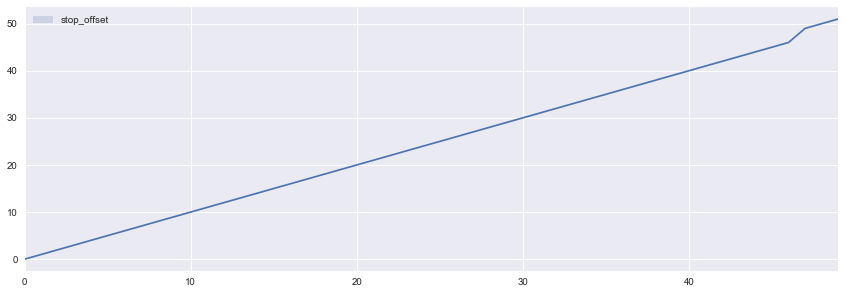

In [44]:
plt.figure(figsize=(15, 5), dpi=70)
sns.tsplot([df_split_trip['stop_offset']],
           time=df_split_trip.index,
          legend=True)
sns.plt.legend(labels = ['stop_offset']) 
sns.plt.show()

By plotting 'stop_offset' against index in a line plot we can visualize the outliers mentioned in the step above. We have two big jumps that may indicate missing data. Let's slice our dataframe to make sure that they are liked

In [45]:
df_split_trip[73:77]

,level_0,index,rt_trip_id,rt_stop_id,stop_offset,departure,lat,lng,distance_prev,departure_date


So that's it ! The jumps we saw in the graph correspond to missing records.

#### Hypothses:  There are more missing records in other routes. Let's come up with a way to identify all the missing records through all the routes. 

This way we'll be able to identify stops that are not emitting data, Let's write a sliding window function that will help us find the just discovered anomalies in all the routes and at the same time return data frames that provide us with details of the stops for which we have no data across routes, this is a type of spatial hotspot.


In [46]:
# Discovers anomalies over the stop_offset serie od values by sliding a window of size two and making sure that the 
# value at rightmost end of the window differs positively from the leftmost one only my one.

def find_missing_stop_offset(df_route, trip_id):
#     df_route.sort_values("stop_offset", inplace=True) 

#     df_route = df_route.reset_index(drop=False)
    serie = df_route['stop_offset'].values
    spatial_hotspots_list = []
    for i in range(len(serie)):
        if i+1 >= len(serie):
            break
            
        # If the ith number differs positively by more than 1 then we have an outlier
        if serie[i+1] > serie[i]+1:
            index_i = df_route.index[df_route['stop_offset'] == serie[i]].tolist()[0]
            dict_spatial_hotspot = {'rt_trip_id':trip_id, 
                     'start_rt_stop_id':df_route.iloc[index_i].rt_stop_id,
                     'start_stop_offset': df_route.iloc[index_i].stop_offset,
                     'start_lat': df_route.iloc[index_i].lat,
                     'start_lng': df_route.iloc[index_i].lng,
                     'end_rt_stop_id':df_route.iloc[index_i+1].rt_stop_id,
                     'end_stop_offset': df_route.iloc[index_i+1].stop_offset,
                     'end_lat': df_route.iloc[index_i+1].lat,
                     'end_lng': df_route.iloc[index_i+1].lng,}
            spatial_hotspots_list.append(dict_spatial_hotspot)
    df_hotspots_for_trip = pd.DataFrame(spatial_hotspots_list)
    return df_hotspots_for_trip

Let's test it on the dataframe that we were exploring above to see if it finds the same missing rows.

In [47]:
df_spatial_hotspots = find_missing_stop_offset(df_split_trip, sample_route_id)
df_spatial_hotspots.head()

,end_lat,end_lng,end_rt_stop_id,end_stop_offset,rt_trip_id,start_lat,start_lng,start_rt_stop_id,start_stop_offset
0,45.581979,-73.626079,51037,49,204063694,45.578814,-73.615584,61784,46


Indeed it does find the blind areas in the trip that we had just seen above along with another one (stop_offset from 57 to 59) that we had not spotted with the intuitive analysis above. Let's run this same process on all the routes so we can identify all the hotspots across all routes. This information will be of good value to the company since we will identify the stops from which we did not receive any events through Montreal for the period of emission of this data.


***The following few cells will identify the geographical areas for which we did not recive stop related data***

In [48]:
def find_missing_spots(grouped_dataframe):
    df_spatial_hotspots_list = []
    for trip_id, group in grouped_dataframe:

        df_list_trips = split_trips(group)
        spatial_hotspot_per_trip_list = []

        for trip in df_list_trips:
            spatial_hotspot_per_trip_list.append(find_missing_stop_offset(trip, trip_id))

        df_spatial_hotspots_list.append(pd.concat(spatial_hotspot_per_trip_list))

    return pd.concat(df_spatial_hotspots_list)    

In [49]:
if path.exists('data/3_results/df_spatial_hotspots.csv') == False:
    df_spatial_hotspots = df_spatial_hotspots.reset_index(drop=True)
    df_spatial_hotspots.head()

The dataframe 'df_spatial_hotspots' contains all the locations between 2 stops across all trips in which we are blind (we have no data for them). We will save it to disk in case we need to refer to it in the future.


In [50]:
if path.exists('data/3_results/df_spatial_hotspots.csv') == False:
    df_spatial_hotspots.to_csv ('data/df_spatial_hotspots.csv', index = None, header=True)

In [51]:
# df_spatial_hotspots.shape()

We have 3268 different hotspots through all the routes.

## Feature engineering

In [52]:
import utm
import math
import numpy as np

###  Distance

Let's calculate the distance between two stops on our own in order to assess the quality of the distance_prev column. We will calculate the distance in a straight line between two stops using first the library UTM (Bidirectional UTM-WGS84 converter for python) and a euclidean distance function made by us.

This will allow us to know if our distance_prev function is provides straight line distances or better.

In [53]:
def calculate_euclidean_distance(x1,y1,x2,y2):  
    utm_org = utm.from_latlon(x1, y1)
    utm_dest = utm.from_latlon(x2, y2)
    dist = math.sqrt((utm_dest[0] - utm_org[0])**2 + (utm_dest[1] - utm_org[1])**2)  
    return dist  

In [54]:
distance = calculate_euclidean_distance(45.459726, -73.544160, 45.452648, -73.548198)
distance

847.4886498684139

In [55]:
#  df_list_trips[0].apply(lambda row: row.lat + row.lng, axis=1)
def calculate_distances(dataframe):
    distances = []
    for index, row in dataframe.iterrows():
        distance = 0
        if index > 0:
            previous_row = dataframe.iloc[index-1]
            distance = calculate_euclidean_distance(previous_row.lat, previous_row.lng, row.lat, row.lng)
        distances.append(distance)
    return distances

In [56]:
distances = calculate_distances(df_split_trip)
df_split_trip.insert(len(df_split_trip.columns), "dist_to_prev", distances, True) 

In [57]:
df_split_trip.head()

,level_0,index,rt_trip_id,rt_stop_id,stop_offset,departure,lat,lng,distance_prev,departure_date,dist_to_prev
0,0,111255,204063694,54269,0,1568638740,45.550548,-73.655055,0.0,2019-09-16 12:59:00,0.000000
1,1,111256,204063694,61241,1,1568638860,45.551789,-73.650271,554.0,2019-09-16 13:01:00,398.113600
2,2,111257,204063694,61117,2,1568638920,45.553471,-73.650172,226.0,2019-09-16 13:02:00,187.052274
3,3,111258,204063694,50466,3,1568638980,45.554496,-73.653760,302.0,2019-09-16 13:03:00,302.359194
4,4,111259,204063694,50420,4,1568639040,45.555440,-73.656970,272.0,2019-09-16 13:04:00,271.644700


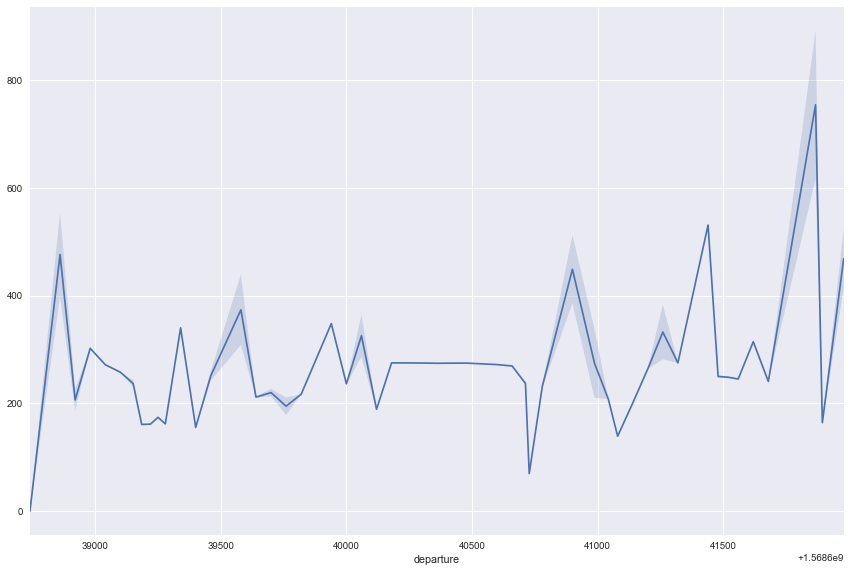

In [64]:
plt.figure(figsize=(15, 10), dpi=70)
sns.tsplot([df_split_trip['distance_prev'], df_split_trip['dist_to_prev']],
           time=df_split_trip['departure'],
          legend=True)
sns.plt.show()

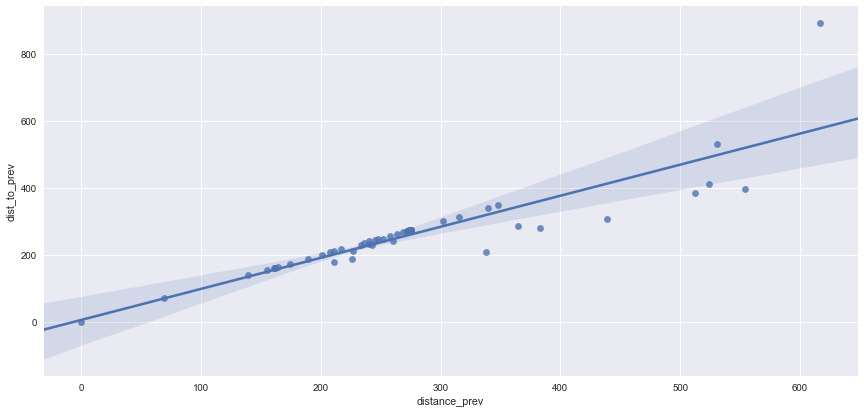

In [65]:
plt.figure(figsize=(15, 7), dpi=70)
sns.regplot(x="distance_prev", y="dist_to_prev", data=df_split_trip);
# sns.plt.legend(labels = ['dist_to_start']) 
sns.plt.show()

In [66]:
df_split_trip.loc[df_split_trip['dist_to_prev'] > 1500]

,level_0,index,rt_trip_id,rt_stop_id,stop_offset,departure,lat,lng,distance_prev,departure_date,dist_to_prev,dist_to_start


We have some problems with our calculation of time given the gps coordinates!!

We can see that our calculated distances are almost all the time smaller that the ones that were given (ditance_prev). This tells us that the provided values are a better measurement of distances between stops. It might even be that they approximate the full trayectory of the bus.

This also gives us more confidence on using ditance_prev to conmpute speeds and a 'naive eta'.

#### Distance to start

This is another feature that might come in handy. The distance of each stop to the start.

In [67]:
def distance_to_start(dataframe):
    distances = [0]
    distance_sum = 0
    for index, row in dataframe.iterrows():
        distance_sum += row.distance_prev + sum(distances)
        distances.append(distance_sum)
    return distances[:len(distances)-1]

In [68]:
distances = distance_to_start(df_split_trip)
df_split_trip.insert(len(df_split_trip.columns), "dist_to_start", distances, True) 

In [69]:
df_split_trip.head()

,level_0,index,rt_trip_id,rt_stop_id,stop_offset,departure,lat,lng,distance_prev,departure_date,dist_to_prev,dist_to_start,dist_to_start
0,0,111255,204063694,54269,0,1568638740,45.550548,-73.655055,0.0,2019-09-16 12:59:00,0.000000,0.0,0.0
1,1,111256,204063694,61241,1,1568638860,45.551789,-73.650271,554.0,2019-09-16 13:01:00,398.113600,0.0,0.0
2,2,111257,204063694,61117,2,1568638920,45.553471,-73.650172,226.0,2019-09-16 13:02:00,187.052274,554.0,554.0
3,3,111258,204063694,50466,3,1568638980,45.554496,-73.653760,302.0,2019-09-16 13:03:00,302.359194,1334.0,1334.0
4,4,111259,204063694,50420,4,1568639040,45.555440,-73.656970,272.0,2019-09-16 13:04:00,271.644700,3524.0,3524.0


### Time

Since we have been provided with 'departure_date' we can use it as a threshold to judge whether the predictions are accurate or not. It can also be used to create an optimal user arrival time feature ('arrival_ax_date') by subtracting a constant (optimum_interval) to 'departure_date'. The size of the constant will represent the length of the interval of time in minutes that will define the segment in which it is best for the user to arrive.

For example if we set optimum_interval to 5 minutes then we would be considering that up to 5 minutes before the bus arrived, the user would be happy. This is a bit too long. Maybe one minute, arriving 1 minute before the bus arrives would be very convenient since the waiting time would be minimized a lot. We'll use 1.5 minutes value for now.


#### Aproximate time of arrival (arrival_ax_date)
Let's define arrival_ax_date = departure_date - 1 min. This feature will be significantly closer to the true value of the ETA since arrival only happens shortly after departure (this will not be true for all cases). Creating this feature will allow us to train our models around a date that is 'closer' to the true ETA. This feature will be used as the independent variable (labels to train) in the modeling section.

#### Time in seconds to previous stop (time_sec_prev)
We will calculate the time in seconds to the last stop. This feature will be of crucial importance when computing the speed to previous stop further down. We will compute the difference between current and previous 'departure_time's. To calculate the time in seconds between two consecutive bus departures 


In [74]:
def calculate_time_previous_stop(dataframe):
    times = [0]
    dates = dataframe['departure_date'].values
    for index, row in dataframe.iterrows():
        time = 0
        if index < len(dates)-1:
            diff = pd.to_datetime(dates[index+1]) - pd.to_datetime(row.departure_date)
            time = (diff/np.timedelta64(1,'D'))*86400
        
        times.append(time)
    return times[:len(times)-1]

def calculate_arrival_aprox_time(dataframe, optimum_interval):
    user_optimal_times = []
    for index, row in dataframe.iterrows():
        # Calculate optimal time for user arrival (one minute before bus departure)
        user_optimal = pd.to_datetime(row.departure_date) - pd.Timedelta(seconds = optimum_interval)
    
        user_optimal_times.append(user_optimal)
    return user_optimal_times 

In [75]:
times = calculate_time_previous_stop(df_split_trip)
user_optimal_times = calculate_arrival_aprox_time(df_split_trip, 30)
df_split_trip.insert(len(df_split_trip.columns), "time_sec_prev", times, True) 
df_split_trip.insert(len(df_split_trip.columns), "arrival_ax_date", user_optimal_times, True)


In [76]:
df_split_trip.head()

,level_0,index,rt_trip_id,rt_stop_id,stop_offset,departure,lat,lng,distance_prev,departure_date,dist_to_prev,dist_to_start,dist_to_start,time_sec_prev,arrival_ax_date
0,0,111255,204063694,54269,0,1568638740,45.550548,-73.655055,0.0,2019-09-16 12:59:00,0.000000,0.0,0.0,0.0,2019-09-16 12:58:30
1,1,111256,204063694,61241,1,1568638860,45.551789,-73.650271,554.0,2019-09-16 13:01:00,398.113600,0.0,0.0,120.0,2019-09-16 13:00:30
2,2,111257,204063694,61117,2,1568638920,45.553471,-73.650172,226.0,2019-09-16 13:02:00,187.052274,554.0,554.0,60.0,2019-09-16 13:01:30
3,3,111258,204063694,50466,3,1568638980,45.554496,-73.653760,302.0,2019-09-16 13:03:00,302.359194,1334.0,1334.0,60.0,2019-09-16 13:02:30
4,4,111259,204063694,50420,4,1568639040,45.555440,-73.656970,272.0,2019-09-16 13:04:00,271.644700,3524.0,3524.0,60.0,2019-09-16 13:03:30


### Speed

This will probably be the most important feature when we come to modeling since we will directly use it to compute ETAs in two simple models below. 

In [77]:
def calculate_speed(dataframe):
    speeds = []
    for index, row in dataframe.iterrows():
        speed = 0
        if float(row.time_sec_prev) > 0:
            speed = float(row.distance_prev) / float(row.time_sec_prev)
        speeds.append(speed)
    return speeds

In [78]:
speeds = calculate_speed(df_split_trip)
df_split_trip.insert(len(df_split_trip.columns), "speed_mps_prev", speeds, True) 

In [79]:
df_split_trip.head()

,level_0,index,rt_trip_id,rt_stop_id,stop_offset,departure,lat,lng,distance_prev,departure_date,dist_to_prev,dist_to_start,dist_to_start,time_sec_prev,arrival_ax_date,speed_mps_prev
0,0,111255,204063694,54269,0,1568638740,45.550548,-73.655055,0.0,2019-09-16 12:59:00,0.000000,0.0,0.0,0.0,2019-09-16 12:58:30,0.000000
1,1,111256,204063694,61241,1,1568638860,45.551789,-73.650271,554.0,2019-09-16 13:01:00,398.113600,0.0,0.0,120.0,2019-09-16 13:00:30,4.616667
2,2,111257,204063694,61117,2,1568638920,45.553471,-73.650172,226.0,2019-09-16 13:02:00,187.052274,554.0,554.0,60.0,2019-09-16 13:01:30,3.766667
3,3,111258,204063694,50466,3,1568638980,45.554496,-73.653760,302.0,2019-09-16 13:03:00,302.359194,1334.0,1334.0,60.0,2019-09-16 13:02:30,5.033333
4,4,111259,204063694,50420,4,1568639040,45.555440,-73.656970,272.0,2019-09-16 13:04:00,271.644700,3524.0,3524.0,60.0,2019-09-16 13:03:30,4.533333


### Feature engineering the full dataset

Let's ingeneer the same features in all the dataset and save it for more complex modeling.


In [80]:
def enhance_dataset(df_grouped_by_trip):
    df_enhanced_trips_list = []
    for trip_id, group in df_grouped_by_trip:
        print('Trip id: ' + str(trip_id))
        
        df_list_trips = tools.split_trips(group)
        print('All recoords for trip: ' + str(group.shape))
        print('Trips in data: ' + str(len(df_list_trips)))
        
        df_list_trips_enhanced = []

        for trip in df_list_trips:
            print(trip.head())
            print(trip.shape)
            print('Stops in trip : ' + str(trip.shape[0]))
            
            # Distances
            distances = distance_to_start(trip)
            trip.insert(len(trip.columns), "dist_to_start", distances, True) 
            
            # Time
            times = calculate_time_previous_stop(trip)
            print(len(times))
            trip.insert(len(trip.columns), "time_sec_prev", times, True) 
            
            user_optimal_times = calculate_arrival_aprox_time(trip, 90)
            trip.insert(len(trip.columns), "arrival_ax_date", user_optimal_times, True)
            
            # Speed
            speeds = calculate_speed(trip)
            trip.insert(len(trip.columns), "speed_mps_prev", speeds, True)  
            
            print('After enhancing, Stops in trip : ' + str(trip.shape[0])) 
            
            df_list_trips_enhanced.append(trip)
        
        enriched = pd.concat(df_list_trips_enhanced)
        assert group.shape[0] == enriched.shape[0]
        
        df_enhanced_trips_list.append(enriched)

    return pd.concat(df_enhanced_trips_list) 

In [2]:
if path.exists('data/3_modeling/enhanced_data.csv') == False:
    df_enhanced_data = enhance_dataset(df_grouped_by_trip)
    df_enhanced_data.to_csv ('data/3_modeling/enhanced_data.csv', index = None, header=True)
else:
    df_enhanced_data = pd.read_csv('data/3_modeling/enhanced_data.csv')

In [82]:
df_enhanced_data.sort_index(inplace=True)
df_enhanced_data.head()

,index,rt_trip_id,rt_stop_id,stop_offset,departure,lat,lng,distance_prev,departure_date,dist_to_start,time_sec_prev,arrival_ax_date,speed_mps_prev
0,22211,201874894,60693,1,1568608765,45.448844,-73.552496,219.0,2019-09-16 04:39:25,0.0,0.0,2019-09-16 04:37:55,0.0
0,448781,204032213,52786,0,1568658600,45.501436,-73.562137,0.0,2019-09-16 18:30:00,0.0,0.0,2019-09-16 18:28:30,0.0
0,427884,204032211,53869,0,1568655720,45.484970,-73.558189,0.0,2019-09-16 17:42:00,0.0,0.0,2019-09-16 17:40:30,0.0
0,427850,204032210,52146,0,1568653260,45.494700,-73.580483,0.0,2019-09-16 17:01:00,0.0,0.0,2019-09-16 16:59:30,0.0
0,4486,202595718,52543,29,1568607000,45.514368,-73.568477,237.0,2019-09-16 04:10:00,0.0,0.0,2019-09-16 04:08:30,0.0


## ETA - Simple model


We should have enough data for modeling now. Let’s build a couple of basic models by making use of the features that were engineered. Our basic models will make use of the laws of classical mechanics (speed = distance/time) to approximate the time of arrival.

By looking at the data ordered for each trip we can easily discover a sense of sequentiality. As one stop follows the other we can make use of the *** n *** previous speeds to compute an average speed and use it to estimate eta like this:

*** ETA = arrival_ax_date - (distance_prev/average_speed) ***

By taking ***arrival_ax_date*** as ***departure_date - constant*** we can make sure that we are predicting for a decent interval of time in which the user will be satisfied (attempting to arrive shortly before the bus leaves)
One of our models will receive a parameter called *memory*, this will tell it how many stops to remember so we can calculate an average speed based on the # *memory* previous speeds. The other one will take the average speed over the full route.


In [83]:
def predict_eta_with_memory(dataframe, memory):
    speeds = dataframe['speed_mps_prev'].values
    etas = []
    for index, row in dataframe.iterrows():
        eta = 0
        if memory <= index:
            previous_speeds = speeds[index-memory:index+1]
            time_seconds = row.distance_prev / np.mean(previous_speeds)
            try:
                eta = pd.to_datetime(row.arrival_ax_date) + pd.to_timedelta(time_seconds, unit='s') 
            except:
                print('Time: ' + str(row))
                print('time: ' + str(time_seconds))
                raise ValueError 
            
        etas.append(eta)
    return etas

def predict_eta_average(dataframe):
    speeds = dataframe['speed_mps_prev'].values
    etas = []
    for index, row in dataframe.iterrows():
        average_speed = np.mean(speeds) 
        if average_speed > 0:
            time_seconds = row.distance_prev / average_speed
            try:
                eta = pd.to_datetime(row.arrival_ax_date) + pd.to_timedelta(time_seconds, unit='s') 
            except:
                print('Time: ' + str(row))
                print('time: ' + str(time_seconds))
                raise ValueError 
        etas.append(eta)
    return etas
    

In [84]:
# Predict eta using route average speed as parameter
etas_speed_av = predict_eta_average(df_split_trip)

In [85]:
# Predict eta using the previous 3 speed values along with the current one to calculate a memory average to be used
etas_m5 = predict_eta_with_memory(df_split_trip, 5)

In [86]:
df_split_trip.insert(len(df_split_trip.columns), "eta_speed_av", etas_speed_av, True) 
df_split_trip.insert(len(df_split_trip.columns), "etas_m5", etas_m5, True) 

In [87]:
df_split_trip.head(10)

,level_0,index,rt_trip_id,rt_stop_id,stop_offset,departure,lat,lng,distance_prev,departure_date,dist_to_prev,dist_to_start,dist_to_start,time_sec_prev,arrival_ax_date,speed_mps_prev,eta_speed_av,etas_m5
0,0,111255,204063694,54269,0,1568638740,45.550548,-73.655055,0.0,2019-09-16 12:59:00,0.000000,0.0,0.0,0.0,2019-09-16 12:58:30,0.000000,2019-09-16 12:58:30.000000,0
1,1,111256,204063694,61241,1,1568638860,45.551789,-73.650271,554.0,2019-09-16 13:01:00,398.113600,0.0,0.0,120.0,2019-09-16 13:00:30,4.616667,2019-09-16 13:02:37.317085,0
2,2,111257,204063694,61117,2,1568638920,45.553471,-73.650172,226.0,2019-09-16 13:02:00,187.052274,554.0,554.0,60.0,2019-09-16 13:01:30,3.766667,2019-09-16 13:02:21.938017,0
3,3,111258,204063694,50466,3,1568638980,45.554496,-73.653760,302.0,2019-09-16 13:03:00,302.359194,1334.0,1334.0,60.0,2019-09-16 13:02:30,5.033333,2019-09-16 13:03:39.403898,0
4,4,111259,204063694,50420,4,1568639040,45.555440,-73.656970,272.0,2019-09-16 13:04:00,271.644700,3524.0,3524.0,60.0,2019-09-16 13:03:30,4.533333,2019-09-16 13:04:32.509471,0
5,5,111260,204063694,50383,5,1568639100,45.556331,-73.660019,258.0,2019-09-16 13:05:00,257.774533,9208.0,9208.0,60.0,2019-09-16 13:04:30,4.300000,2019-09-16 13:05:29.292072,2019-09-16 13:05:39.573034
6,6,111261,204063694,50396,6,1568639151,45.558273,-73.658967,243.0,2019-09-16 13:05:51,230.878716,24086.0,24086.0,51.0,2019-09-16 13:05:21,4.764706,2019-09-16 13:06:16.844859,2019-09-16 13:06:14.970604
7,7,111262,204063694,50407,7,1568639185,45.559613,-73.658185,161.0,2019-09-16 13:06:25,160.917918,63035.0,63035.0,34.0,2019-09-16 13:05:55,4.735294,2019-09-16 13:06:32.000091,2019-09-16 13:06:30.601966
8,8,111263,204063694,50419,8,1568639220,45.560953,-73.657393,162.0,2019-09-16 13:07:00,161.215111,164937.0,164937.0,35.0,2019-09-16 13:06:30,4.628571,2019-09-16 13:07:07.229906,2019-09-16 13:07:04.720191
9,9,111264,204063694,50425,9,1568639250,45.562401,-73.656530,174.0,2019-09-16 13:07:30,174.423268,431777.0,431777.0,30.0,2019-09-16 13:07:00,5.800000,2019-09-16 13:07:39.987677,2019-09-16 13:07:36.298013


 

#### eta_speed_av
This model calculates eta using the global average speed over the route. This is a simple approach that requires knowledge on the global average speed per route,

Pros: 
- Can compute values starting from the first row
- Simple to calculate.

Cons: 
- Will need to always know the average speed per route

#### eta_m3 model
We have created a simple model that computes ETA making use of the 3 previous speed values in order to calculate a moving average speed and use it to compute the ETA.

Pros:
- Simple to calculate 

Cons:
- The first #memory predictions are not accesible due to lack of information to compute the mean speed
- Highly sensitive to drastic changes in previous values. 
- Takes very fe params into consideration
- Would need longer sequence to be able to learn sequential patterns better



## Evaluating our predictions

***How can we judge what a good prediction is?***
In order to judge how accurate our ETA predictions we must take into consideration the impact they would have on our users. 
Let’s say for example in the case of a predicted  date for after the bus left (departure_date) then it must be penalized more than when the provided date was before the bus left. In one case the user misses the bus and in the other he/she just waits a bit for the bus at the stop. 
Our scoring algorithm should follow the following:
- If predicted date is after departure_date then:
***score = 0***. 

- If  predicted date lands in a small interval of  k  seconds around ***arrival_ax_date*** then we give the highest score possible:
***score = 1***.

- If ETA prediction is smaller than ***arrival_ax_date - k =  *** then we'll gradually assign smaller scores as the prediction is further back in the past over a finite interval of time of length m. Interval ***[arrival_ax_date - k - m, arrival_ax_date - k] ***.
The score in this case will be: ***score =  SUM ( (if pred in mth interval) x 1/m)***


*** The code for the following function is in tools.py ***

In [88]:
score_speed_av, _ = tools.score_eta_predictions(df_split_trip,'eta_speed_av', 'arrival_ax_date', 20)
score_memory_5, _ = tools.score_eta_predictions(df_split_trip,'etas_m5', 'arrival_ax_date', 20)

In [89]:
print('Score for average speed model: ' + str(score_speed_av))
print('Score for memory (5) model: ' + str(score_memory_5))

Score for average speed model: 0.02
Score for memory (5) model: 0.02


Seems like non our simple models have small scores using our scoring algorithm. In the simple models we computed ETA as a linear combination of the time and distance features that we had. This is not enough since there are a lot more variables that would come into play when predicting ETA. This approach is interesting to study but it won't provide us with a trustable predictive model.

Let's move into another notebook for some more robust modeling.
